In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/6888/as22/fruits-360_dataset.zip /content
!unzip /content/fruits-360_dataset.zip


# Problem 1

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, utils, initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


base_path = '/content/fruits-360_dataset/fruits-360'
train_path = base_path + '/Training'
test_path = base_path + '/Test'


BATCH_SIZE = 1000
IMG_SIZE = (75, 75)
SEED = 42


In [28]:
train_gen, valid_gen = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.15,
    subset="both",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

test_gen = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label


train_gen = train_gen.map(normalize_img)
valid_gen = valid_gen.map(normalize_img)
test_gen = test_gen.map(normalize_img)



train_gen = train_gen.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_gen = valid_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_gen = test_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


Found 67692 files belonging to 131 classes.
Using 57539 files for training.
Using 10153 files for validation.
Found 22688 files belonging to 131 classes.


Train dataset:


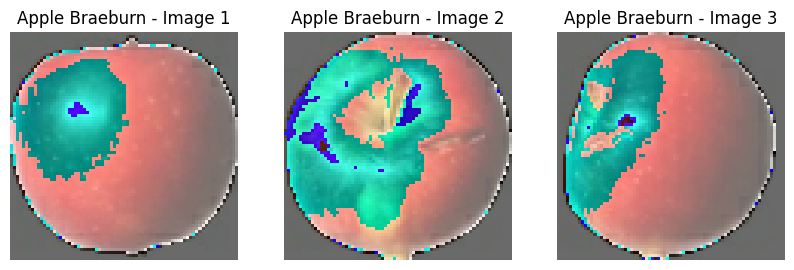

Test dataset:


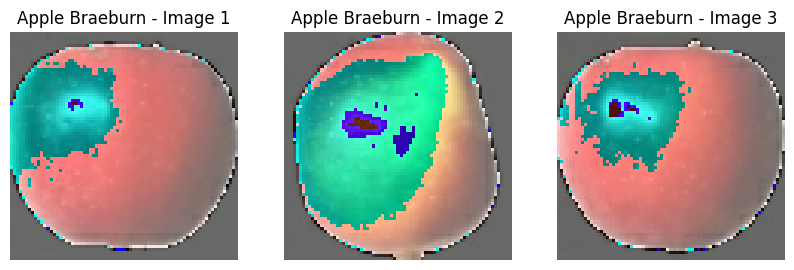

In [27]:
import matplotlib.pyplot as plt

# Function to display images with captions
def show_images(dataset, num_images, class_name):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(1, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"{class_name} - Image {i+1}")
            plt.axis("off")
    plt.show()

print('Train dataset:')

# Show 3 training images of the first class
first_class_name = class_names[0]
filtered_train_gen = train_gen.unbatch().filter(lambda x, y: tf.equal(tf.argmax(y, axis=-1), 0)).batch(3)
show_images(filtered_train_gen, 3, first_class_name)

print('Test dataset:')

# Show 3 testing images of the first class
filtered_test_gen = test_gen.unbatch().filter(lambda x, y: tf.equal(tf.argmax(y, axis=-1), 0)).batch(3)
show_images(filtered_test_gen, 3, first_class_name)


In [26]:
def create_model1(dropout_rate):
    weight_initializer = initializers.GlorotUniform(seed=99)
    bias_initializer = initializers.Zeros()

    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.02),
    ])

    model = models.Sequential()

    model.add(data_augmentation)

    # First Conv layer
    model.add(layers.Conv2D(64, (3,3), strides=(1,1), activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer, input_shape=(75, 75, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Conv layer
    model.add(layers.Conv2D(128, (3,3), strides=(1,1), activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer))
    model.add(layers.BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())

    # Dense Layers
    model.add(layers.Dense(256, activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer))
    model.add(layers.Dense(131, activation='softmax', kernel_initializer=weight_initializer, bias_initializer=bias_initializer))

    return model


def create_model2(dropout_rate):
    weight_initializer = initializers.GlorotUniform(seed=99)
    bias_initializer = initializers.Zeros()

    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.02),
    ])

    model = models.Sequential()

    model.add(data_augmentation)

    # First Conv layer
    model.add(layers.Conv2D(64, (3,3), strides=(1,1), activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer, input_shape=(75, 75, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Conv layer
    model.add(layers.Conv2D(128, (3,3), strides=(1,1), activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Third Conv layer
    model.add(layers.Conv2D(256, (3,3), strides=(1,1), activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer))
    model.add(layers.BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())

    # Dense Layers
    model.add(layers.Dense(512, activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer))
    model.add(layers.Dense(131, activation='softmax', kernel_initializer=weight_initializer, bias_initializer=bias_initializer))

    return model


def create_model_bonus(dropout_rate):
    weight_initializer = initializers.GlorotUniform(seed=99)
    bias_initializer = initializers.Zeros()

    inputs = layers.Input(shape=(75, 75, 3))

    x0 = layers.experimental.preprocessing.RandomFlip("horizontal")(inputs)
    x00 = tf.keras.layers.experimental.preprocessing.RandomRotation(0.02)(x0)

    # First Conv layer
    x1 = layers.Conv2D(128, (3,3), strides=(1,1), padding = 'same', activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer)(x0)
    x2 = layers.MaxPooling2D(pool_size=(2, 2))(x1)
    x2_reduced = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(x2)  # Reduce size for skip connection

    # Second Conv layer
    x3 = layers.Conv2D(128, (3,3), strides=(1,1), activation='relu', padding = 'same', kernel_initializer=weight_initializer, bias_initializer=bias_initializer)(x2)
    x4 = layers.MaxPooling2D(pool_size=(2, 2))(x3)

    # Concatenate for skip connection
    skip_connection = layers.concatenate([x4, x2_reduced])

    # Third Conv layer
    x5 = layers.Conv2D(256, (3,3), strides=(1,1), activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer)(skip_connection)
    x6 = layers.BatchNormalization(momentum=0.99, epsilon=0.001)(x5)
    x7 = layers.Dropout(dropout_rate)(x6)
    x8 = layers.MaxPooling2D(pool_size=(2, 2))(x7)

    flat = layers.Flatten()(x8)

    # Dense Layers
    dense1 = layers.Dense(512, activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer)(flat)
    outputs = layers.Dense(131, activation='softmax', kernel_initializer=weight_initializer, bias_initializer=bias_initializer)(dense1)

    model = models.Model(inputs=inputs, outputs=outputs)

    return model




Epoch 1/50
58/58 [==============================] - 7s 81ms/step - loss: 0.9204 - accuracy: 0.7971 - val_loss: 3.4188 - val_accuracy: 0.1914
Epoch 2/50
58/58 [==============================] - 5s 79ms/step - loss: 0.0162 - accuracy: 0.9958 - val_loss: 2.4103 - val_accuracy: 0.6480
Epoch 3/50
58/58 [==============================] - 5s 79ms/step - loss: 0.0046 - accuracy: 0.9990 - val_loss: 1.4887 - val_accuracy: 0.9502
Epoch 4/50
58/58 [==============================] - 5s 79ms/step - loss: 8.1533e-04 - accuracy: 0.9999 - val_loss: 0.8095 - val_accuracy: 0.9888
Epoch 5/50
58/58 [==============================] - 5s 79ms/step - loss: 4.1524e-04 - accuracy: 1.0000 - val_loss: 0.4187 - val_accuracy: 0.9885
Epoch 6/50
58/58 [==============================] - 5s 79ms/step - loss: 4.6338e-04 - accuracy: 0.9999 - val_loss: 0.2174 - val_accuracy: 0.9877
Epoch 7/50
58/58 [==============================] - 5s 79ms/step - loss: 2.1315e-04 - accuracy: 1.0000 - val_loss: 0.0862 - val_accuracy: 0.99

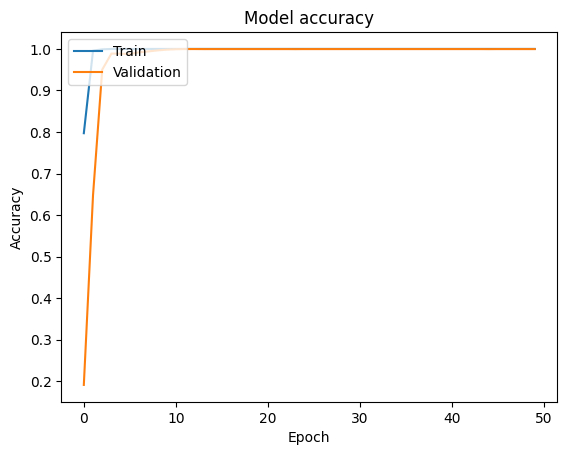

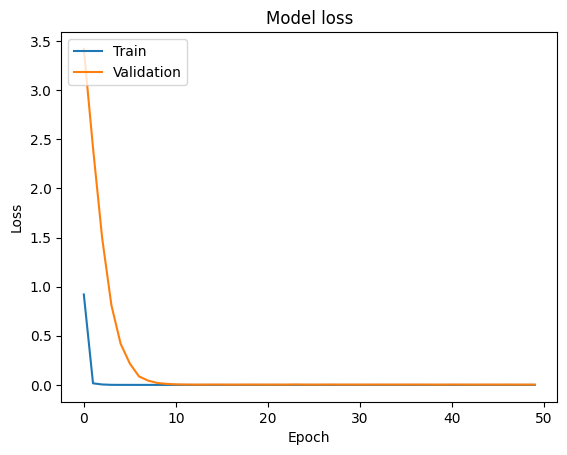

In [32]:
model1_1 = create_model1(0.1)

model1_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model1_1.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=50,
)

test_loss, test_accuracy = model1_1.evaluate(test_gen)
print(f'Test accuracy: {test_accuracy}')

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Epoch 1/50
58/58 [==============================] - 7s 82ms/step - loss: 1.4259 - accuracy: 0.7097 - val_loss: 3.3122 - val_accuracy: 0.3310
Epoch 2/50
58/58 [==============================] - 5s 79ms/step - loss: 0.0144 - accuracy: 0.9969 - val_loss: 2.4918 - val_accuracy: 0.6176
Epoch 3/50
58/58 [==============================] - 5s 79ms/step - loss: 0.0041 - accuracy: 0.9995 - val_loss: 1.9225 - val_accuracy: 0.6691
Epoch 4/50
58/58 [==============================] - 5s 79ms/step - loss: 0.0037 - accuracy: 0.9994 - val_loss: 1.4304 - val_accuracy: 0.7342
Epoch 5/50
58/58 [==============================] - 5s 79ms/step - loss: 0.0047 - accuracy: 0.9988 - val_loss: 1.1919 - val_accuracy: 0.6931
Epoch 6/50
58/58 [==============================] - 5s 79ms/step - loss: 0.0208 - accuracy: 0.9959 - val_loss: 2.0182 - val_accuracy: 0.4490
Epoch 7/50
58/58 [==============================] - 5s 79ms/step - loss: 0.0654 - accuracy: 0.9835 - val_loss: 2.3317 - val_accuracy: 0.4640
Epoch 8/50
58

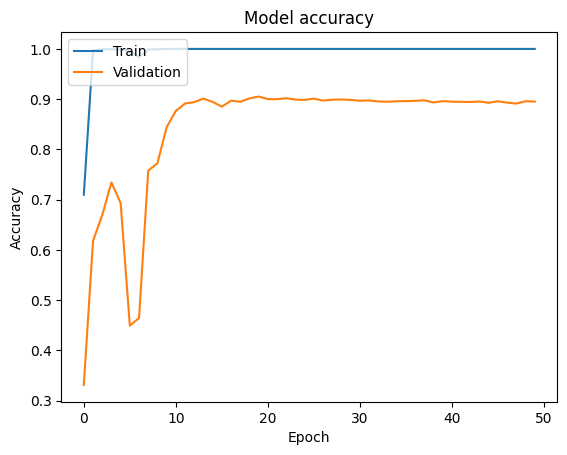

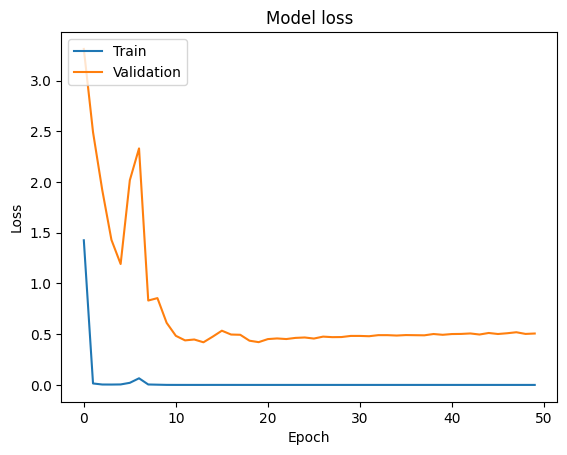

In [31]:
model1_3 = create_model1(0.3)

model1_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model1_3.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=50,
)

test_loss, test_accuracy = model1_3.evaluate(test_gen)
print(f'Test accuracy: {test_accuracy}')

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/50
58/58 [==============================] - 7s 81ms/step - loss: 1.5701 - accuracy: 0.6865 - val_loss: 3.4337 - val_accuracy: 0.3979
Epoch 2/50
58/58 [==============================] - 5s 80ms/step - loss: 0.0242 - accuracy: 0.9946 - val_loss: 2.7268 - val_accuracy: 0.6651
Epoch 3/50
58/58 [==============================] - 5s 80ms/step - loss: 0.0078 - accuracy: 0.9986 - val_loss: 2.1393 - val_accuracy: 0.7156
Epoch 4/50
58/58 [==============================] - 5s 79ms/step - loss: 0.0055 - accuracy: 0.9987 - val_loss: 1.8869 - val_accuracy: 0.6544
Epoch 5/50
58/58 [==============================] - 5s 79ms/step - loss: 0.0040 - accuracy: 0.9992 - val_loss: 1.3714 - val_accuracy: 0.6989
Epoch 6/50
58/58 [==============================] - 5s 79ms/step - loss: 0.0013 - accuracy: 0.9999 - val_loss: 0.9873 - val_accuracy: 0.7665
Epoch 7/50
58/58 [==============================] - 5s 79ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.7149 - val_accuracy: 0.8066
Epoch 8/50
58

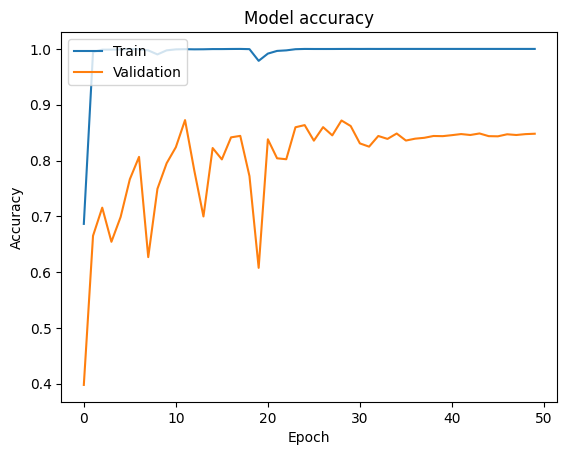

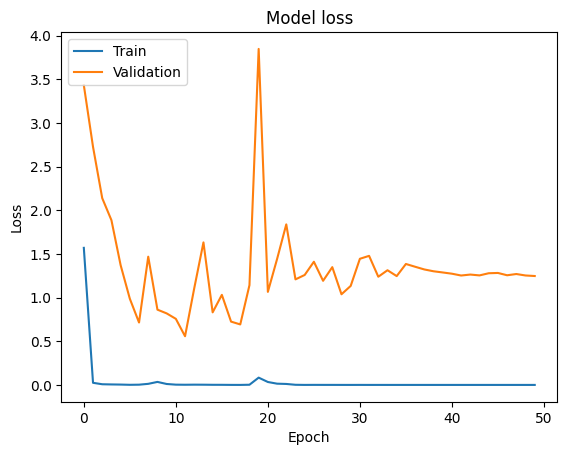

In [30]:
model1_5 = create_model1(0.5)

model1_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model1_5.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=50,
)

test_loss, test_accuracy = model1_5.evaluate(test_gen)
print(f'Test accuracy: {test_accuracy}')

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/50
58/58 [==============================] - 7s 79ms/step - loss: 0.9592 - accuracy: 0.7776 - val_loss: 3.1817 - val_accuracy: 0.2306
Epoch 2/50
58/58 [==============================] - 4s 77ms/step - loss: 0.0290 - accuracy: 0.9926 - val_loss: 2.1260 - val_accuracy: 0.5123
Epoch 3/50
58/58 [==============================] - 4s 77ms/step - loss: 0.0122 - accuracy: 0.9974 - val_loss: 1.0967 - val_accuracy: 0.8742
Epoch 4/50
58/58 [==============================] - 4s 76ms/step - loss: 0.0233 - accuracy: 0.9946 - val_loss: 1.5561 - val_accuracy: 0.6054
Epoch 5/50
58/58 [==============================] - 4s 76ms/step - loss: 0.0123 - accuracy: 0.9969 - val_loss: 0.6050 - val_accuracy: 0.8448
Epoch 6/50
58/58 [==============================] - 4s 76ms/step - loss: 0.0055 - accuracy: 0.9986 - val_loss: 0.3434 - val_accuracy: 0.8909
Epoch 7/50
58/58 [==============================] - 4s 77ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.6363 - val_accuracy: 0.8303
Epoch 8/50
58

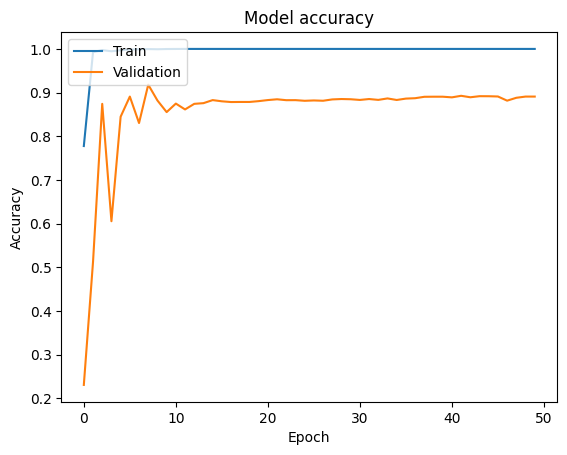

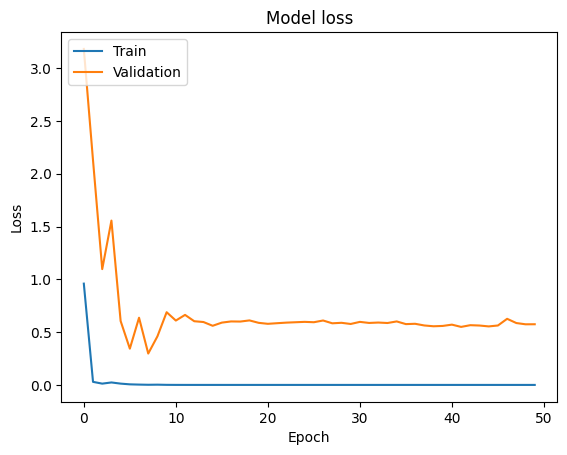

In [34]:
model2 = create_model2(0.3)

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model2.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=50,
)

test_loss, test_accuracy = model2.evaluate(test_gen)
print(f'Test accuracy: {test_accuracy}')

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/50
58/58 [==============================] - 9s 117ms/step - loss: 0.8980 - accuracy: 0.7950 - val_loss: 3.2388 - val_accuracy: 0.1473
Epoch 2/50
58/58 [==============================] - 7s 114ms/step - loss: 0.0106 - accuracy: 0.9981 - val_loss: 1.8330 - val_accuracy: 0.5482
Epoch 3/50
58/58 [==============================] - 7s 114ms/step - loss: 0.0027 - accuracy: 0.9998 - val_loss: 0.7850 - val_accuracy: 0.9397
Epoch 4/50
58/58 [==============================] - 7s 114ms/step - loss: 0.0013 - accuracy: 0.9999 - val_loss: 0.3477 - val_accuracy: 0.9884
Epoch 5/50
58/58 [==============================] - 7s 114ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.1762 - val_accuracy: 0.9848
Epoch 6/50
58/58 [==============================] - 7s 114ms/step - loss: 4.6521e-04 - accuracy: 1.0000 - val_loss: 0.0642 - val_accuracy: 0.9964
Epoch 7/50
58/58 [==============================] - 7s 114ms/step - loss: 3.4357e-04 - accuracy: 1.0000 - val_loss: 0.0310 - val_accuracy: 0.997

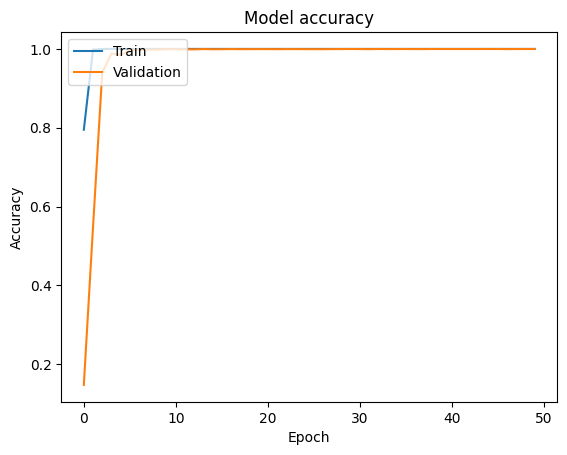

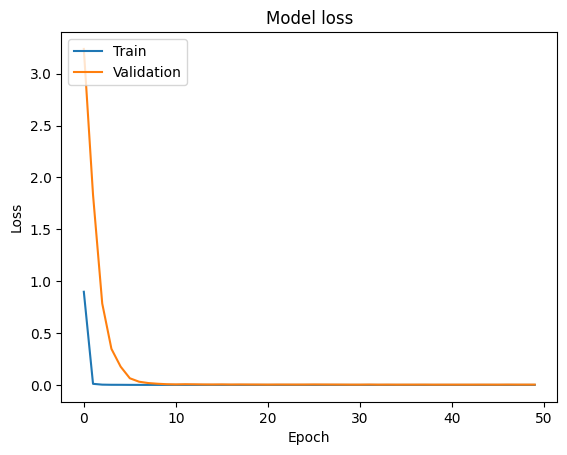

In [33]:
model_bonus = create_model_bonus(0.1)

model_bonus.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_bonus.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=50,
)

test_loss, test_accuracy = model_bonus.evaluate(test_gen)
print(f'Test accuracy: {test_accuracy}')

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Problem 2

In [17]:
from tensorflow.keras.datasets import imdb

# Load the data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=2000)
word_index = imdb.get_word_index()


1641221/1641221 [==============================] - 1s 1us/step


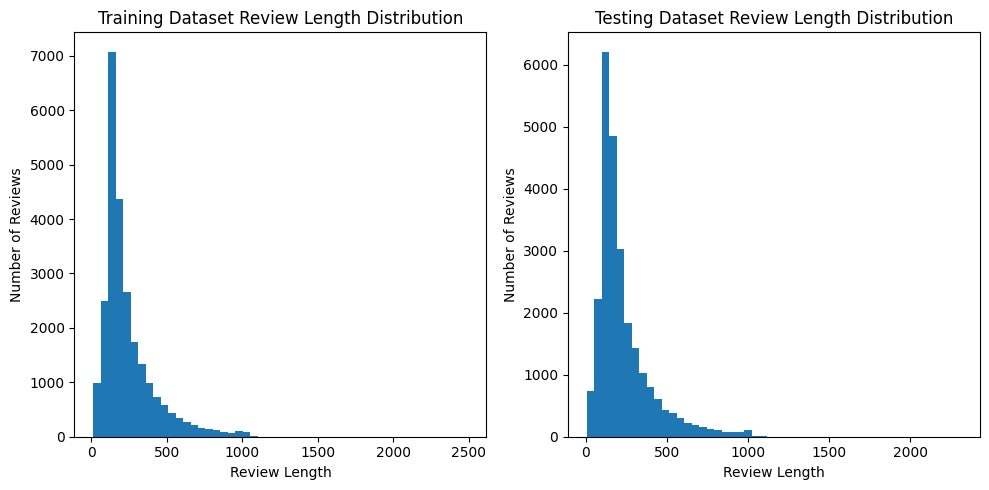

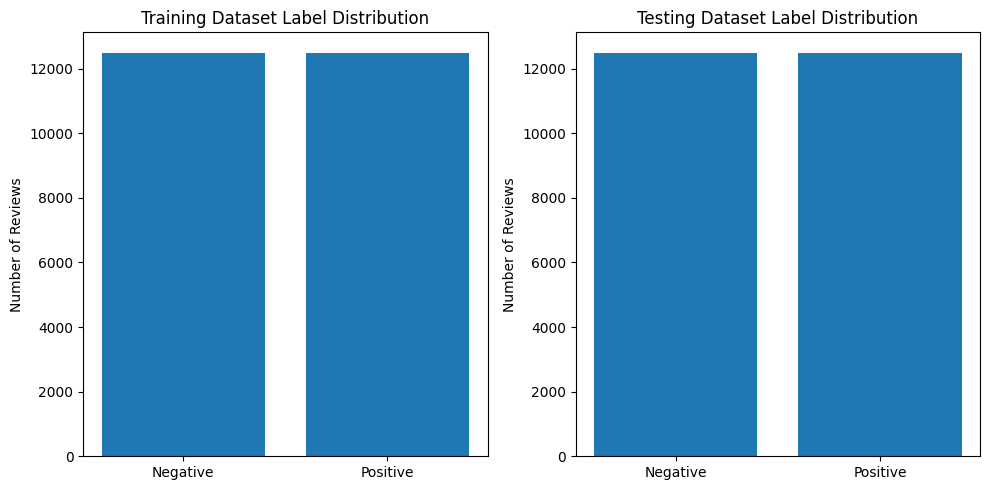

In [18]:
import matplotlib.pyplot as plt

# Load the dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=2000)

# Plotting the review length distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist([len(review) for review in x_train], bins=50)
plt.title('Training Dataset Review Length Distribution')
plt.xlabel('Review Length')
plt.ylabel('Number of Reviews')

plt.subplot(1, 2, 2)
plt.hist([len(review) for review in x_test], bins=50)
plt.title('Testing Dataset Review Length Distribution')
plt.xlabel('Review Length')
plt.ylabel('Number of Reviews')

plt.tight_layout()
plt.show()

# Plotting the label distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(['Negative', 'Positive'], [(y_train == 0).sum(), (y_train == 1).sum()])
plt.title('Training Dataset Label Distribution')
plt.ylabel('Number of Reviews')

plt.subplot(1, 2, 2)
plt.bar(['Negative', 'Positive'], [(y_test == 0).sum(), (y_test == 1).sum()])
plt.title('Testing Dataset Label Distribution')
plt.ylabel('Number of Reviews')

plt.tight_layout()
plt.show()


In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad the sequences
x_train = pad_sequences(x_train, maxlen=300)
x_test = pad_sequences(x_test, maxlen=300)

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

model = Sequential()
model.add(Embedding(input_dim=2000, output_dim=16, input_length=300))
model.add(Conv1D(128, 3, activation='relu', strides=1, padding='valid'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))


In [36]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Split 1000 samples for validation
x_val = x_train[:1000]
y_val = y_train[:1000]
x_train_partial = x_train[1000:]
y_train_partial = y_train[1000:]

history = model.fit(x_train_partial, y_train_partial, epochs=30, batch_size=32, validation_data=(x_val, y_val))


Epoch 1/30
750/750 [==============================] - 39s 49ms/step - loss: 0.4708 - accuracy: 0.7707 - val_loss: 0.3666 - val_accuracy: 0.8380
Epoch 2/30
750/750 [==============================] - 6s 8ms/step - loss: 0.3111 - accuracy: 0.8671 - val_loss: 0.3368 - val_accuracy: 0.8500
Epoch 3/30
750/750 [==============================] - 5s 7ms/step - loss: 0.2580 - accuracy: 0.8941 - val_loss: 0.3289 - val_accuracy: 0.8610
Epoch 4/30
750/750 [==============================] - 5s 6ms/step - loss: 0.2244 - accuracy: 0.9090 - val_loss: 0.3299 - val_accuracy: 0.8560
Epoch 5/30
750/750 [==============================] - 3s 5ms/step - loss: 0.1966 - accuracy: 0.9239 - val_loss: 0.3318 - val_accuracy: 0.8540
Epoch 6/30
750/750 [==============================] - 3s 4ms/step - loss: 0.1721 - accuracy: 0.9356 - val_loss: 0.3350 - val_accuracy: 0.8540
Epoch 7/30
750/750 [==============================] - 3s 4ms/step - loss: 0.1497 - accuracy: 0.9465 - val_loss: 0.3727 - val_accuracy: 0.8460
Epoc

In [37]:
results = model.evaluate(x_test, y_test)
print(f'Test loss: {results[0]}, Test accuracy: {results[1]}')


782/782 [==============================] - 2s 2ms/step - loss: 1.0682 - accuracy: 0.8518
Test loss: 1.0681837797164917, Test accuracy: 0.8518400192260742


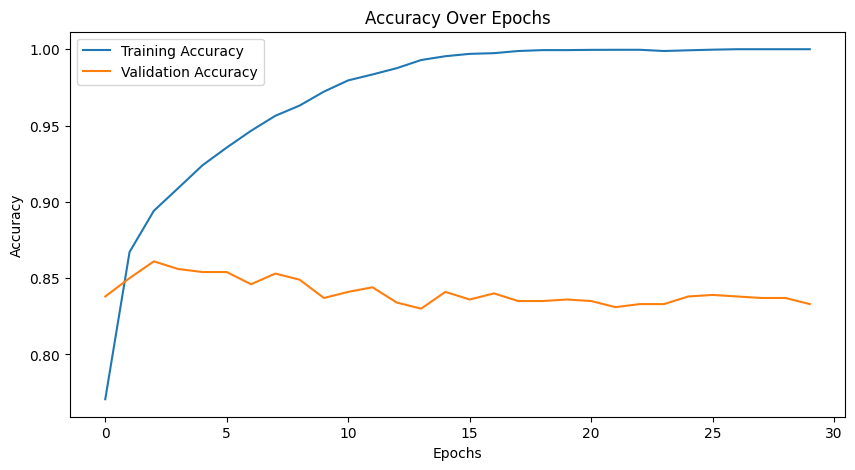

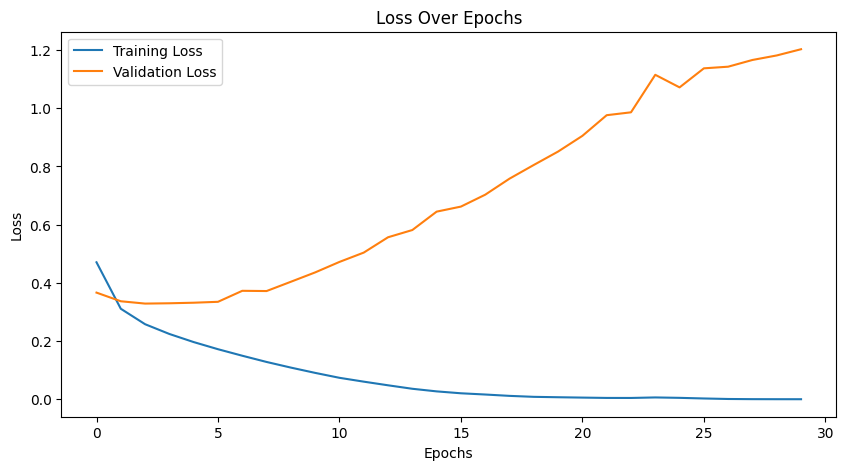

In [38]:
import matplotlib.pyplot as plt

history_dict = history.history

# Plot accuracy
plt.figure(figsize=(10,5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10,5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


**Model Accuracy and Loss Curves Report:**

**1. Loss Curves:** 
- **Training Loss**: It initially starts off high at around 0.5 but quickly drops to 0.1 within 10 epochs. After that, it stabilizes and gradually continues to decrease.
- **Validation Loss**: It starts around 0.4, decreases before the 5th epoch, but then begins to increase.
- **Test Loss**: 1.06, which is considered high.

**2. Accuracy Curves:** 
- **Training Accuracy**: Begins at a low value but rapidly climbs, nearing 100% as epochs increase.
- **Validation Accuracy**: There is an increase in the first two epochs to about 86%, followed by a plateauing trend with a slight decrease, stabilizing at around 80-85%.
- **Test Accuracy**: 85.18%.

**Analysis of Model Performance:**

**1. Overfitting**
The model appears to be overfitting the training data. Evidence includes:
- The training loss decreasing and stabilizing, but the validation loss steadily increasing.
- The training accuracy approaching 100%, indicating almost perfect performance on the training data, while the validation accuracy plateaus at a much lower value.

**2. Examination of Curves:**
- **Plateaus**: The validation accuracy shows a plateauing trend from around 5 epochs onward, suggesting that the model might not benefit significantly from further training beyond this point.
- **Sharp Changes**: A sharp decline in training loss during the initial epochs indicates rapid learning during this period.
- **Divergence**: As epochs increase, a clear divergence between training and validation curves emerges. Training accuracy continues to rise, but validation accuracy stabilizes. Similarly, while training loss stabilizes, validation loss increases.

Considering the test results, the model performs reasonably well on unseen data with a test accuracy of 85.18%. However, the higher test loss compared to training suggests there's still room for improvement.

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential()
model.add(Embedding(input_dim=2000, output_dim=16, input_length=300))
model.add(Conv1D(128, 3, activation='relu', strides=1, padding='valid'))
# Add Normalization
model.add(BatchNormalization())
# Add dropout
model.add(Dropout(0.5))
model.add(Conv1D(128, 3, activation='relu', strides=1, padding='valid'))
# Add Normalization
model.add(BatchNormalization())
# Add dropout
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

Epoch 1/100
6125/6125 [==============================] - 61s 10ms/step - loss: 0.9305 - accuracy: 0.5503 - val_loss: 0.5687 - val_accuracy: 0.6780 - lr: 1.0000e-04
Epoch 2/100
6125/6125 [==============================] - 28s 5ms/step - loss: 0.6411 - accuracy: 0.6747 - val_loss: 0.4247 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 3/100
6125/6125 [==============================] - 27s 4ms/step - loss: 0.4961 - accuracy: 0.7697 - val_loss: 0.3663 - val_accuracy: 0.8520 - lr: 1.0000e-04
Epoch 4/100
6125/6125 [==============================] - 27s 4ms/step - loss: 0.4267 - accuracy: 0.8109 - val_loss: 0.3386 - val_accuracy: 0.8640 - lr: 1.0000e-04
Epoch 5/100
6125/6125 [==============================] - 27s 4ms/step - loss: 0.3896 - accuracy: 0.8300 - val_loss: 0.3281 - val_accuracy: 0.8480 - lr: 1.0000e-04
Epoch 6/100
6125/6125 [==============================] - 27s 4ms/step - loss: 0.3589 - accuracy: 0.8482 - val_loss: 0.3127 - val_accuracy: 0.8720 - lr: 1.0000e-04
Epoch 7/100
6125/6125

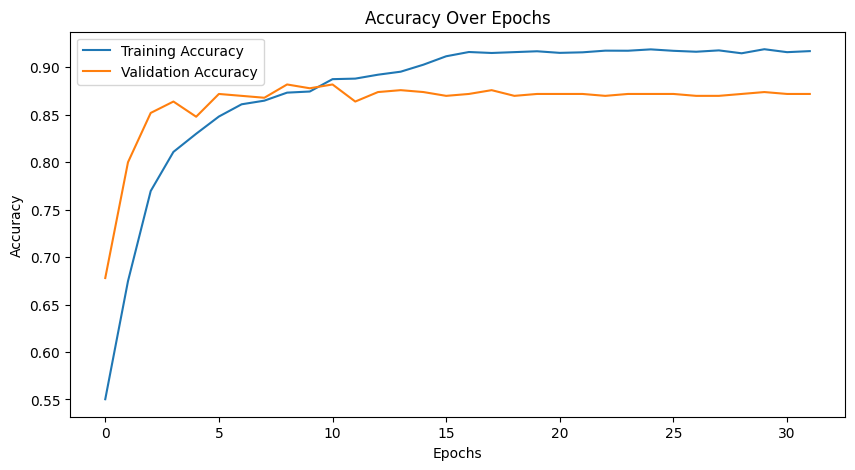

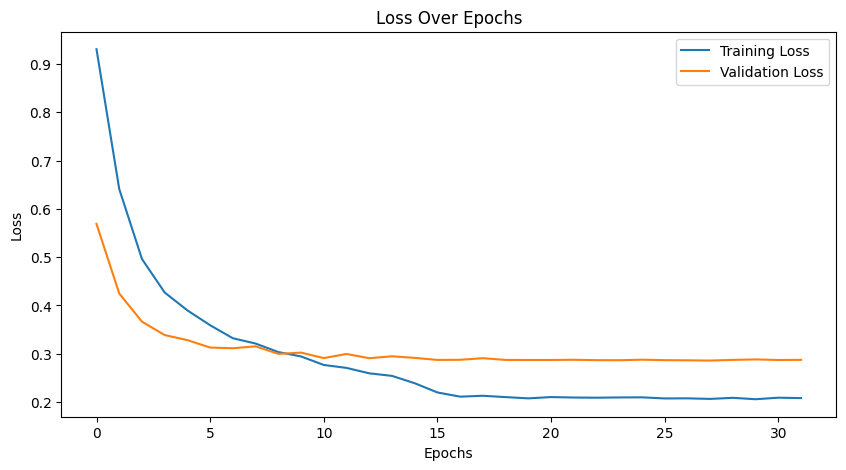

In [61]:

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_delta=1e-5)

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)  # stops after 4 epochs of no improvement

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Split 500 samples for validation
x_val = x_train[:500]
y_val = y_train[:500]
x_train_partial = x_train[500:]
y_train_partial = y_train[500:]

history = model.fit(x_train_partial, y_train_partial, epochs=100, batch_size=4, validation_data=(x_val, y_val), callbacks=[early_stopping, reduce_lr])

results = model.evaluate(x_test, y_test)
print(f'Test loss: {results[0]}, Test accuracy: {results[1]}')

import matplotlib.pyplot as plt

history_dict = history.history

# Plot accuracy
plt.figure(figsize=(10,5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10,5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

By adding an additional Conv1D layer, the model becomes more complex in order to learn more intricate patterns. However, this can also result in a more severe overfitting issue. To mitigate this problem, I include a dropout layer and a batch normalization layer for each Conv1D layer. Through some experimentation, I observed that these measures can enhance the accuracy of the test results. During training, I decrease the initial learning rate of the Adam optimizer and implement techniques such as ReduceLROnPlateau and early stopping. Additionally, I reduce the batch size to improve the accuracy of the model. Ultimately, I achieve an accuracy of 88.3% on the test dataset, slightly surpassing previous results.